## 1. Import Library

In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import optuna.integration.lightgbm as op_lgb
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score 
from sklearn.metrics import confusion_matrix

import utils

## 2. Load data

In [209]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
genre = pd.read_csv("../data/genre_labels.csv")

In [210]:
train.drop(["index"], axis=1, inplace=True)
train

,genre,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,instrumentalness,tempo,region
0,10,11,201094,0.112811,0.157247,0.187841,-1.884852,0.893918,0.363568,0.390108,0.888884,121-152,region_H
1,8,69,308493,0.101333,0.346563,0.554444,-5.546495,0.874409,0.193892,0.161497,0.123910,153-176,region_I
2,3,43,197225,0.496420,0.265391,0.457642,-9.255670,0.439933,0.217146,0.369057,0.166470,64-76,region_E
3,10,45,301092,0.165667,0.245533,0.356578,-5.088788,0.868704,0.377025,0.226677,0.175399,177-192,region_C
4,3,57,277348,0.190720,0.777578,0.830479,-3.933896,0.650149,0.169323,0.222488,0.226030,97-120,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4041,10,38,246309,0.128795,0.329718,0.575830,-5.252543,0.509531,0.193781,0.187331,0.158197,121-152,region_P
4042,5,23,208734,0.778732,0.228757,0.394283,-14.225700,0.322871,0.253108,0.141218,0.295608,121-152,region_D
4043,10,30,407016,0.402050,0.462374,0.672265,-10.711253,0.646571,0.228189,0.152270,0.163483,97-120,region_E
4044,10,25,204957,0.208096,0.465511,0.523514,-7.855946,0.508910,0.247820,0.202238,0.210184,77-96,region_R


In [211]:
test.drop(["index"], axis=1, inplace=True)
test

,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,instrumentalness,tempo,region
0,43,192465,0.559812,0.565035,0.522237,-12.217087,0.620510,0.389727,0.214989,0.161924,77-96,region_I
1,40,226536,0.134002,0.542547,0.493128,-2.612846,0.853089,0.163106,0.184183,0.155460,121-152,unknown
2,58,215385,0.140537,0.643086,0.533189,-3.439684,0.834416,0.429304,0.167352,0.179191,121-152,region_K
3,49,254494,0.266406,0.456733,0.410583,-10.830424,0.534261,0.151830,0.174403,0.186061,77-96,region_D
4,50,230934,0.351907,0.526235,0.645625,-9.099337,0.612474,0.319161,0.157594,0.184142,97-120,region_E
...,...,...,...,...,...,...,...,...,...,...,...,...
4041,34,366668,0.117208,0.316026,0.502289,-2.909329,0.824708,0.320241,0.206592,0.198859,121-152,region_B
4042,53,240081,0.225540,0.391226,0.483655,-5.013634,0.630808,0.163884,0.205218,0.179438,121-152,region_I
4043,48,217839,0.215571,0.828567,0.689747,-8.974036,0.697981,0.318250,0.123748,0.135281,121-152,region_H
4044,45,249612,0.205074,0.730554,0.580581,-1.915320,0.828423,0.360663,0.165837,0.162821,121-152,region_B


In [212]:
genre

,genre,labels
0,country,0
1,electronic,1
2,folk,2
3,hip-hop,3
4,jazz,4
5,latin,5
6,classic,6
7,other-light-music,7
8,pop,8
9,religious,9


## 3. 既存の特徴量のみで学習
- Features: tempoとregionを含む
    - tempo: tempo_min, tempo_max, tempo_diff
    - region: one_hot_vecotorにする (unkownのまま)
- train, valid: 8:2でランダムに分割
- Model: light gbm (パラメータチューニングなし)

In [213]:
# # tempo

# def make_tempo_features(tempo):
#     """
#     tempo = train["tempo"] or test["tempo"]
#     """
#     # min, max
#     tempo = tempo.str.split("-", expand=True)
#     tempo.columns = ["tempo_min", "tempo_max"]
#     tempo = tempo[["tempo_min", "tempo_max"]].astype(int)
    
#     # sum
#     tempo["tempo_sum"] = tempo["tempo_min"] + tempo["tempo_max"]
#     # diff
#     tempo["tempo_diff"] = tempo["tempo_max"] - tempo["tempo_min"]
#     # mean
#     tempo["tempo_mean"] = tempo["tempo_sum"] / 2

#     return tempo

tempo_train = utils.make_tempo_features(tempo=train["tempo"])
tempo_test = utils.make_tempo_features(tempo=test["tempo"])

In [214]:
# # region
# def make_region_features(region):
#     """
#     region = train["region"] or test["region"]
#     """
#     return pd.get_dummies(region)

region_train = utils.make_region_features(region=train["region"])
region_test = utils.make_region_features(region=test["region"])

In [215]:
# testには、'region_M'が存在しない
region_train_columns = region_train.columns.to_numpy()
region_test_columns = region_test.columns.to_numpy()
region_only_train = np.array([region_train_column for region_train_column in region_train_columns if region_train_column not in region_test_columns])
# print(region_only_train) > array(['region_M'], dtype='<U8')

# 'region_M'の挿入位置を指定
region_M_index = np.where(region_train_columns == "region_M")[0][0]

# region_testに、'region_M'を追加
region_test.insert(int(region_M_index), "region_M", pd.Series(np.zeros(test.shape[0]), dtype="uint8"))

## 4. モデルの学習

In [216]:
# Train
X = train.drop(["genre", "tempo", "region"], axis=1)
X = pd.concat([X, tempo_train, region_train], axis=1)
y = train["genre"]

# ハイパーパラメータ設定
params = {  
    "objective": 'multiclass',
    "num_class": 11,
    "metric": "multi_logloss",
    "learning_rate": 0.01,
    "verbosity": -1,
    "seed": 42,
}

# Training model
# Use stratified k fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for cv_num, (train_index, valid_index) in enumerate(kf.split(X, y)):
    # cv
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    
    # make dataset
    trains = lgb.Dataset(X_train, label=y_train)
    valids = lgb.Dataset(X_valid, label=y_valid)
    
    # train
    model = lgb.train(params, trains, valid_sets=valids,
                     verbose_eval=False,
                     num_boost_round=100,
                     early_stopping_rounds=5)
    
    y_pred = model.predict(X_valid).argmax(1)
    score = f1_score(y_valid, y_pred, average='macro')
    cv_scores.append(score)
    print(f"Folds: {cv_num}, val_score: {score:.4f}")
    
print(f"Mean-CV-F1Score: {sum(cv_scores) / len(cv_scores): .4f}")

Folds: 0, val_score: 0.4035
Folds: 1, val_score: 0.4220
Folds: 2, val_score: 0.4824
Folds: 3, val_score: 0.4239
Folds: 4, val_score: 0.4620
Mean-CV-F1Score:  0.4388


In [217]:
 # Test
X_test = test.drop(["tempo", "region"], axis=1)
X_test = pd.concat([X_test, tempo_test, region_test], axis=1)

y_test = model.predict(X_test).argmax(1)
print(X_test.shape, y_test.shape)

(4046, 36) (4046,)


## 4. 結果を保存
- F1score(macro) = 0.4714456744341993

In [218]:
# Store csv file
sample_submit = pd.read_csv("../data/sample_submit.csv", header=None)
submit = pd.concat([sample_submit.iloc[:, 0], pd.Series(y_test)], axis=1)

In [219]:
submit

,0,0
0,4046,8
1,4047,10
2,4048,8
3,4049,10
4,4050,8
...,...,...
4041,8087,10
4042,8088,8
4043,8089,10
4044,8090,8


In [220]:
# おそらく02_20210417.csvと結果は変わらない
# submit.to_csv("../logs/03_20210420.csv", header=None, index=None)

## 5. 結果の可視化

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

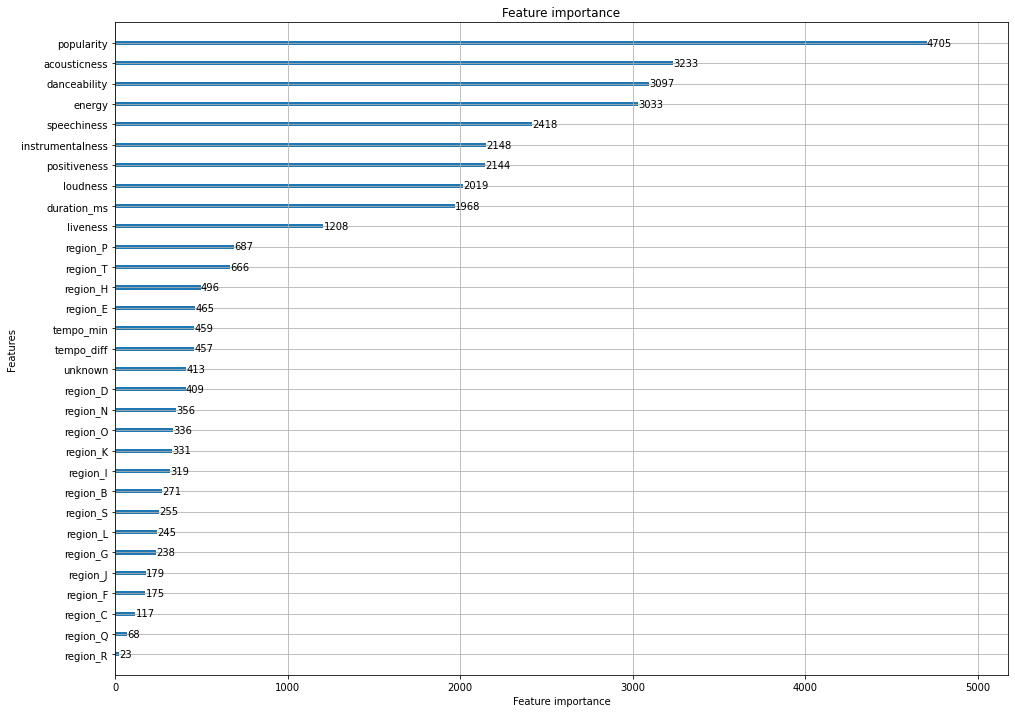

In [221]:
# Feature Importance
lgb.plot_importance(model, figsize=(16, 12))

In [222]:
# feature importanceが0の特徴量
X_train.columns[np.where(model.feature_importance()==0)]

Index(['tempo_max', 'tempo_sum', 'tempo_mean', 'region_A', 'region_M'], dtype='object')